<a href="https://colab.research.google.com/github/MeenaRuwandi/INCS_870_Project_IDSforMinorAttacks/blob/meena/incs870_team4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn
!pip install scikit-learn

In [2]:
!pip install gdown
import gdown

In [3]:
# Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
file_ids = [
    '1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde',  # Replace with actual file ID
    '1fagr2rKW8EN-Psc5UlD9BFfa0rRRF6i3',  # Replace with actual file ID
    '1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq',   # Replace with actual file ID
    '1xr_QBU3Ab42nW1ELl0NUydx4Rbx60TVR']
    #'1MpqHsC5wQSu9CxlhJimz25EVcYubSMhu',
    #'18mKfJHXinmfwPpaYNU2D6xHwq4dQuEuL',
    #'1h1lMHytamf4Kc66NfAfMfBzDbmwM5Ub5',
    #'11__JhC64_D4ezxjF8d0dPNRDJF-TY6Pq'
#]


# Download each file
for i, file_id in enumerate(file_ids):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, f'dataset_{i + 1}.csv', quiet=False)  # Saves as dataset_1.csv, dataset_2.csv, etc.

Downloading...
From (original): https://drive.google.com/uc?id=1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde
From (redirected): https://drive.google.com/uc?id=1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde&confirm=t&uuid=b53a7fa9-3efa-49d5-8a9d-4224d8c7b40b
To: /content/dataset_1.csv
100%|██████████| 225M/225M [00:04<00:00, 51.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1fagr2rKW8EN-Psc5UlD9BFfa0rRRF6i3
From (redirected): https://drive.google.com/uc?id=1fagr2rKW8EN-Psc5UlD9BFfa0rRRF6i3&confirm=t&uuid=a8885b76-93ea-4858-a9e4-0718cc106065
To: /content/dataset_2.csv
100%|██████████| 135M/135M [00:03<00:00, 35.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq
From (redirected): https://drive.google.com/uc?id=1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq&confirm=t&uuid=97cc230e-2c51-4a91-b969-a4e0760276da
To: /content/dataset_3.csv
100%|██████████| 52.0M/52.0M [00:01<00:00, 34.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xr_QBU3Ab42n

In [5]:
dataset_paths = [
    '/content/dataset_1.csv','/content/dataset_2.csv','/content/dataset_3.csv','/content/dataset_4.csv']
    #'/content/dataset_5.csv','/content/dataset_6.csv','/content/dataset_7.csv','/content/dataset_8.csv',
#]

# Make the data frame
dataframes = [pd.read_csv(path) for path in dataset_paths]

# Combine all datasets into one dataframe
combined_dataset = pd.concat(dataframes, ignore_index=True)

In [6]:
combined_dataset.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,...,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06,1.597580e+06
mean,7.265925e+03,1.810044e+07,1.017553e+01,1.135632e+01,5.503592e+02,1.797964e+04,1.930048e+02,1.777891e+01,5.247342e+01,6.226569e+01,...,5.129408e+00,-3.670333e+03,7.929145e+04,4.616986e+04,1.578908e+05,5.308831e+04,1.137177e+07,2.833167e+05,1.160782e+07,1.112820e+07
std,1.750798e+04,3.685830e+07,7.664489e+02,1.021730e+03,1.242696e+04,2.320795e+06,5.279422e+02,4.359763e+01,1.338825e+02,1.846350e+02,...,5.883265e+02,1.408748e+06,6.403377e+05,4.171596e+05,1.043148e+06,5.626373e+05,2.830962e+07,3.265741e+06,2.864680e+07,2.820277e+07
min,0.000000e+00,-4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.700000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.168400e+04,2.000000e+00,2.000000e+00,6.800000e+01,1.400000e+02,4.100000e+01,2.000000e+00,3.700000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.327068e+06,6.000000e+00,5.000000e+00,3.390000e+02,8.150000e+02,2.540000e+02,3.700000e+01,5.200000e+01,8.119570e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553300e+04,1.200000e+08,2.064460e+05,2.760720e+05,1.290000e+07,6.270000e+08,2.482000e+04,2.065000e+03,4.672000e+03,6.429191e+03,...,1.971240e+05,1.380000e+02,1.070000e+08,7.420000e+07,1.070000e+08,1.070000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [7]:
combined_dataset.shape

(1597580, 79)

In [8]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597580 entries, 0 to 1597579
Data columns (total 79 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Destination Port             1597580 non-null  int64  
 1    Flow Duration                1597580 non-null  int64  
 2    Total Fwd Packets            1597580 non-null  int64  
 3    Total Backward Packets       1597580 non-null  int64  
 4   Total Length of Fwd Packets   1597580 non-null  int64  
 5    Total Length of Bwd Packets  1597580 non-null  int64  
 6    Fwd Packet Length Max        1597580 non-null  int64  
 7    Fwd Packet Length Min        1597580 non-null  int64  
 8    Fwd Packet Length Mean       1597580 non-null  float64
 9    Fwd Packet Length Std        1597580 non-null  float64
 10  Bwd Packet Length Max         1597580 non-null  int64  
 11   Bwd Packet Length Min        1597580 non-null  int64  
 12   Bwd Packet Length Mean     

In [9]:
# Pre processing
x = combined_dataset.drop(columns=[' Label'])
y = combined_dataset[' Label']
# Handle missing values
x.fillna(x.mean(), inplace=True)

# Get 'Label' column that indicates attack types
class_distribution = combined_dataset[' Label'].value_counts()
print(class_distribution)

 Label
BENIGN                        1328857
DoS Hulk                       231073
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [10]:
#check for missing values
missing_values=combined_dataset.isnull().sum()
print("missing values in each column :\n", missing_values[missing_values>0])

missing values in each column :
 Flow Bytes/s    1247
dtype: int64


In [41]:
combined_dataset.columns = combined_dataset.columns.str.strip()
print(combined_dataset.columns.tolist())


#fill missing values with the mean value of 'Flow Bytes/s' column with its mean value
meanVal = combined_dataset['Flow Bytes/s'].mean()

#verify if all the missing values are handled
combined_dataset['Flow Bytes/s'].fillna(meanVal, inplace=True)
missingValCheck = combined_dataset.isnull().sum()

#print("missing values after handling : \n", missingValCheck[missingValCheck>0])
print("Missing values after handling:\n", missingValCheck[missingValCheck > 0])




['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

<ipython-input-41-f1fe732fff2e>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_dataset['Flow Bytes/s'].fillna(meanVal, inplace=True)


Missing values after handling:
 Series([], dtype: int64)


In [12]:
print(combined_dataset.columns.tolist())

print(combined_dataset['Flow Bytes/s'].dtype)



['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [13]:
#separating features as X and target variable as Y
X= combined_dataset.drop(columns=['Label'])
Y= combined_dataset['Label']
#print the shape of X and Y
print("features shape",X.shape)
print("Target variable shape", Y.shape)

features shape (1597580, 78)
Target variable shape (1597580,)


In [14]:
import numpy as np

#check for infinity values
infVal=X.isin([np.inf, -np.inf]).sum()
print("Infinity values in each column:\n", infVal[infVal>0])

# Check for excessively large values (based on what you deem large)
large_values = X.apply(lambda x: x > 1e6).sum()
print("Large values in each column: \n", large_values[large_values > 0])

Infinity values in each column:
 Flow Bytes/s      1903
Flow Packets/s    1903
dtype: int64
Large values in each column: 
 Flow Duration                  469030
Total Length of Fwd Packets        19
Total Length of Bwd Packets      1133
Flow Bytes/s                   236863
Flow Packets/s                  25202
Flow IAT Mean                  346156
Flow IAT Std                   419937
Flow IAT Max                   456404
Flow IAT Min                     9772
Fwd IAT Total                  448951
Fwd IAT Mean                   370978
Fwd IAT Std                    386385
Fwd IAT Max                    436099
Fwd IAT Min                     37283
Bwd IAT Total                  272994
Bwd IAT Mean                   225272
Bwd IAT Std                    216373
Bwd IAT Max                    266293
Bwd IAT Min                     37585
Fwd Header Length                  34
Bwd Header Length                  36
Fwd Packets/s                   22230
Bwd Packets/s                      81
Pac

In [15]:
#To Handle infinity values : Replace infinity values with
X.replace([np.inf,-np.inf],np.nan,inplace=True)

#To Handle Large values : Capping extremely large values
X = X.apply(lambda x: np.where(x > 1e6, 1e6, x))  # Example threshold 1e6

# Fill missing values after replacing infinity
X.fillna(X.mean(), inplace=True)

# Check for any remaining missing values
print(X.isnull().sum())



Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 78, dtype: int64


In [16]:
#selecting best features for the training model out of 78 features
#use Random forest algorithm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

#Train a model with Random Forest
rfModel=RandomForestClassifier(n_estimators=100, random_state=42)
rfModel.fit(X,Y)

#Get important feature
importantFeatures=rfModel.feature_importances_

                        Feature  Importance
0              Destination Port    0.074944
41            Packet Length Std    0.073344
54         Avg Bwd Segment Size    0.071691
39            Max Packet Length    0.069448
10        Bwd Packet Length Max    0.059549
13        Bwd Packet Length Std    0.051712
52          Average Packet Size    0.040587
42       Packet Length Variance    0.038030
66       Init_Win_bytes_forward    0.037398
55          Fwd Header Length.1    0.025278
15               Flow Packets/s    0.023301
5   Total Length of Bwd Packets    0.023299
65            Subflow Bwd Bytes    0.023125
12       Bwd Packet Length Mean    0.023027
37                Bwd Packets/s    0.022984
40           Packet Length Mean    0.022955
34            Fwd Header Length    0.020607
3        Total Backward Packets    0.015754
35            Bwd Header Length    0.015707
36                Fwd Packets/s    0.014810


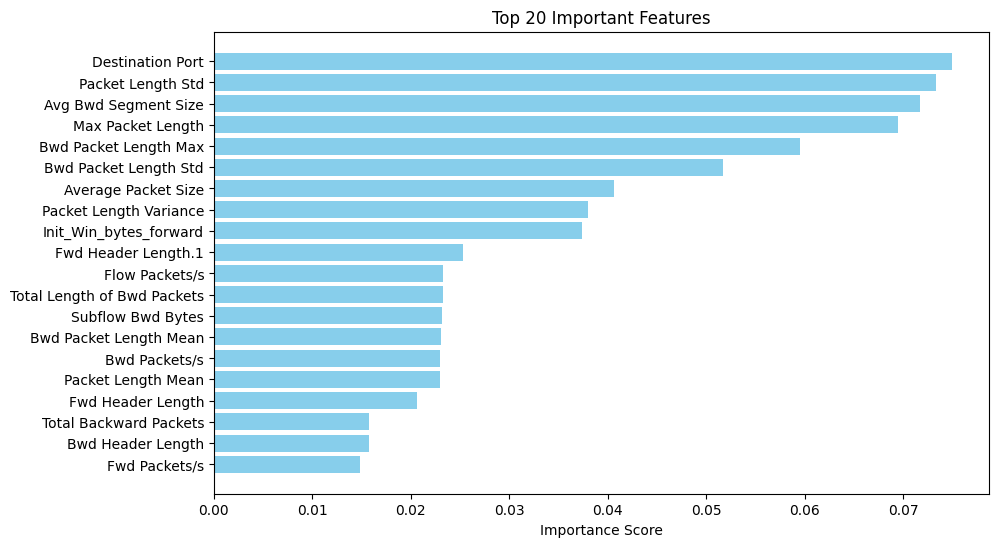

In [17]:
#Creating another Data frame with selected most importand features and their importance factor
importantFeatures_df=pd.DataFrame({
    'Feature' : X.columns,
    'Importance': importantFeatures
})

#Sort the Dataframe by importance scores in decending order
importantFeatures_df = importantFeatures_df.sort_values(by='Importance', ascending=False)

# Display the top important features
print(importantFeatures_df.head(20))  # Change 10 to the number of features you want to display

# Plotting feature importances
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.barh(importantFeatures_df['Feature'][:20], importantFeatures_df['Importance'][:20], color='skyblue')  # Change to top 20
plt.xlabel('Importance Score')
plt.title('Top 20 Important Features')  # Update title to reflect the change
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


In [18]:
importantFeatures_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 61
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Feature     78 non-null     object 
 1   Importance  78 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [19]:
# Assuming 'top_features' contains the names of the 20 important features
top_features = importantFeatures_df.nlargest(20, 'Importance')['Feature']

# Create a new DataFrame with selected features and the target variable
selected_features_df = combined_dataset[top_features.values.tolist() + ['Label']]

# Display the new DataFrame to verify
print(selected_features_df.head())


   Destination Port  Packet Length Std  Avg Bwd Segment Size  \
0                80           0.000000              6.000000   
1               389          56.529599             65.200000   
2                88         671.751541            525.000000   
3               389         704.654082            555.000000   
4                88         704.585067            525.333333   

   Max Packet Length  Bwd Packet Length Max  Bwd Packet Length Std  \
0                  6                      6               0.000000   
1                163                    163              89.278777   
2               1575                   1575             813.326503   
3               3069                   3069             977.480342   
4               1576                   1576             813.842901   

   Average Packet Size  Packet Length Variance  Init_Win_bytes_forward  \
0             9.000000                0.000000                     255   
1            31.125000             3195.595588

In [20]:
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597580 entries, 0 to 1597579
Data columns (total 21 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Destination Port             1597580 non-null  int64  
 1   Packet Length Std            1597580 non-null  float64
 2   Avg Bwd Segment Size         1597580 non-null  float64
 3   Max Packet Length            1597580 non-null  int64  
 4   Bwd Packet Length Max        1597580 non-null  int64  
 5   Bwd Packet Length Std        1597580 non-null  float64
 6   Average Packet Size          1597580 non-null  float64
 7   Packet Length Variance       1597580 non-null  float64
 8   Init_Win_bytes_forward       1597580 non-null  int64  
 9   Fwd Header Length.1          1597580 non-null  int64  
 10  Flow Packets/s               1597580 non-null  float64
 11  Total Length of Bwd Packets  1597580 non-null  int64  
 12  Subflow Bwd Bytes            1597580 non-n

In [21]:
from sklearn.preprocessing import LabelEncoder

#initiate the lable encoder
labelEncoder=LabelEncoder()

#fit the encoder to the lable data
y_encode=labelEncoder.fit_transform(Y)

#check the data type
y_encode.dtype

dtype('int64')

In [29]:
from sklearn.model_selection import train_test_split


#Use features from selected_features_df dataframe and y_encode
x_train,x_test,y_train,y_test=train_test_split(selected_features_df,y_encode,test_size=0.2,random_state=42,stratify=y_encode)

#drop label from x_train and x_test
trainDataset = x_train.drop(columns=['Label'])
testDataset=x_test.drop(columns=['Label'])
#check the shapes of the resulting datsets
print("Traning features set shape:",trainDataset.shape)
print("Test features set shape:",testDataset.shape)
print("Traning Lable set shape:",y_train.shape)
print("Test Lable set shape:",y_test.shape)

Traning features set shape: (1278064, 20)
Test features set shape: (319516, 20)
Traning Lable set shape: (1278064,)
Test Lable set shape: (319516,)


In [37]:
#print the data type of trainDataset
print(type(trainDataset))

#print the unique values of traing Label
unique_values = pd.Series(y_train).unique()
print(unique_values)

#print columns of trainDataset
print(trainDataset.head())

#print columns of testDataset
print(testDataset.head())



<class 'pandas.core.frame.DataFrame'>
[ 0  2  4 11  1  8  5  3  9  7  6 10]
         Destination Port  Packet Length Std  Avg Bwd Segment Size  \
1213637                53          38.060103            108.000000   
821270                139          98.526858            106.266667   
1545423             57303           0.000000              6.000000   
1431910             53117           0.000000              0.000000   
365829                 53          18.475209             72.000000   

         Max Packet Length  Bwd Packet Length Max  Bwd Packet Length Std  \
1213637                108                    108               0.000000   
821270                 440                    440             130.703912   
1545423                  6                      6               0.000000   
1431910                  0                      0               0.000000   
365829                  72                     72               0.000000   

         Average Packet Size  Packet Length Va

{0: 1063086, 1: 8234, 2: 184858, 3: 4399, 4: 4637, 5: 6350, 6: 9, 7: 29, 8: 4717, 9: 1206, 10: 17, 11: 522}


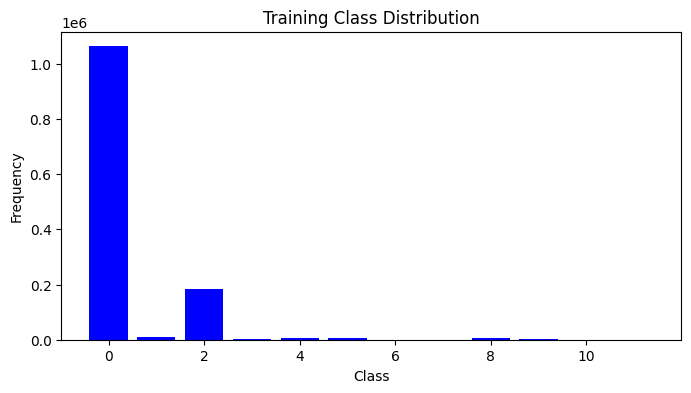

In [38]:
#check the class distribution | use the traning lable set
unique, counts=np.unique(y_train,return_counts=True)
class_distribution_training=dict(zip(unique,counts))#represent the different classes in the dataset as a dictionary
print(class_distribution_training)


#plot the class distribution
plt.figure(figsize=(8,4))
plt.bar(class_distribution_training.keys(),class_distribution_training.values(),color="blue")
plt.title('Training Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [45]:
print(" --- Data processing and cleaning again - before appying SMOTE --- ")
# Check for extremely large values
#print(trainDataset.describe())

#Replace inf values with Nan in traingDataset
trainDataset.replace([np.inf,-np.inf],np.nan, inplace=True)
#Check if any NaN values are present
print(trainDataset.isnull().sum())

#Replace inf values with Nan in testDataset
testDataset.replace([np.inf,-np.inf],np.nan, inplace=True)
#Check if any NaN values are present
print(testDataset.isnull().sum())



 --- Data processing and cleaning again - before appying SMOTE --- 
Destination Port                  0
Packet Length Std                 0
Avg Bwd Segment Size              0
Max Packet Length                 0
Bwd Packet Length Max             0
Bwd Packet Length Std             0
Average Packet Size               0
Packet Length Variance            0
Init_Win_bytes_forward            0
Fwd Header Length.1               0
Flow Packets/s                 1497
Total Length of Bwd Packets       0
Subflow Bwd Bytes                 0
Bwd Packet Length Mean            0
Bwd Packets/s                     0
Packet Length Mean                0
Fwd Header Length                 0
Total Backward Packets            0
Bwd Header Length                 0
Fwd Packets/s                     0
dtype: int64
Destination Port               0
Packet Length Std              0
Avg Bwd Segment Size           0
Max Packet Length              0
Bwd Packet Length Max          0
Bwd Packet Length Std          0
A

In [48]:
#Still have missing values in Flow Packets/s                 406 in testDataset
#Fill NaN values with the median of the 'Flow Packets/s' column
testDataset['Flow Packets/s']=testDataset['Flow Packets/s'].fillna(testDataset['Flow Packets/s'].median())
print(testDataset['Flow Packets/s'].isnull().sum())

#Still have missing values in Flow Packets/s               1497   in trainDataset
#Fill NaN values with the median of the 'Flow Packets/s' column
trainDataset['Flow Packets/s']=trainDataset['Flow Packets/s'].fillna(trainDataset['Flow Packets/s'].median())
print(trainDataset['Flow Packets/s'].isnull().sum())

0
0


In [51]:
#use SMOTE for handle class imbalance
from imblearn.over_sampling import SMOTE

#Apply SMOTE to training features and traing lables
#Create an instance of SMOTE
smote=SMOTE(random_state=42)

#Fit SMOTE to thr training data
x_resampled, y_resampled = smote.fit_resample(trainDataset, y_train)

#check the new class distribution
print("Original traning labled distribution:")
#convert Numpy array into Pandas Series
print(pd.Series(y_train).value_counts())
print("\n Resampled training lables distribution:")
print(pd.Series(y_resampled).value_counts())


Original traning labled distribution:
0     1063086
2      184858
1        8234
5        6350
8        4717
4        4637
3        4399
9        1206
11        522
7          29
10         17
6           9
Name: count, dtype: int64

 Resampled training lables distribution:
0     1063086
2     1063086
4     1063086
11    1063086
1     1063086
8     1063086
5     1063086
3     1063086
9     1063086
7     1063086
6     1063086
10    1063086
Name: count, dtype: int64


    Class number                 Attack name 
0               0                      BENIGN
1               1               DoS GoldenEye
2               2                    DoS Hulk
3               3            DoS Slowhttptest
4               4               DoS slowloris
5               5                 FTP-Patator
6               6                  Heartbleed
7               7                Infiltration
8               8                 SSH-Patator
9               9    Web Attack � Brute Force
10             10  Web Attack � Sql Injection
11             11            Web Attack � XSS
    Class number                 Attack name   Original count   \
0               0                      BENIGN          1063086   
1               1               DoS GoldenEye             8234   
2               2                    DoS Hulk           184858   
3               3            DoS Slowhttptest             4399   
4               4               DoS slowloris             4637   
5     

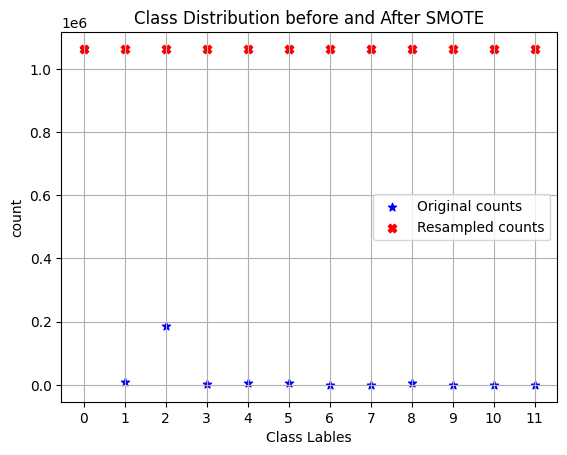

In [60]:
#get the class numbers and attack name by inverse the label ancoding
classNum=range(len(labelEncoder.classes_))
#get orginal class names
attackNames=labelEncoder.inverse_transform(classNum)
#newDataFrame to display class number with corrsponding attack name
class_mapping=pd.DataFrame({'Class number ':classNum,'Attack name ':attackNames})
print(class_mapping)

#plot the out put of oversampling with SMOTE
original_counts=pd.Series(y_train).value_counts().sort_index()
resampled_counts=pd.Series(y_resampled).value_counts().sort_index()

#newDataFrame to display class number with corrsponding attack name
class_mapping=pd.DataFrame({'Class number ':classNum,'Attack name ':attackNames,'Original count ':original_counts,'Re-sampled counts ':resampled_counts})
print(class_mapping)

#create x-axis values for classes
classTypes=np.arange(len(original_counts))
classNames=original_counts.index

#scatter plot for original values
plt.scatter(classNames,original_counts,color='blue',label='Original counts',marker='*')

#Scatter plot for resampled values
plt.scatter(classNames,resampled_counts,color='red',label='Resampled counts',marker='X')

#Set x-tixks to class lables
plt.xticks(classTypes,original_counts.index)

#Add labled and titles
plt.xlabel('Class Lables')
plt.ylabel('count')
plt.title('Class Distribution before and After SMOTE')
plt.legend()
plt.grid()

plt.show()

In [61]:
model=RandomForestClassifier(random_state=42)
model.fit(x_resampled,y_resampled)

KeyboardInterrupt: 